In [1]:
#I shall use what I learned from Coursera's 'Convolutional Neural Networks in TensorFlow' mainly Transfer Learning and Dropout

In [2]:
import csv
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import img_to_array, load_img

In [3]:
from google.colab import files
files.upload() # Browse for the kaggle.json file that you downloaded

# Make directory named kaggle, copy kaggle.json file there, and change the permissions of the file.
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# You can check if everything's okay by running this command.
! kaggle datasets list

# Download and unzip sign-language-mnist dataset into '/usr/local'
! kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset --path '/news' --unzip

Saving kaggle.json to kaggle.json
ref                                                       title                                       size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -----------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/apple-quality                            Apple Quality                              170KB  2024-01-11 14:31:07          11139        261  1.0              
shiivvvaam/top-youtuber-worldwide                         Top YouTubers Worldwide                     83KB  2024-02-05 09:33:23            797         38  1.0              
shiivvvaam/most-watched-movies-and-tv-shows               Most Watched Movies and TV Shows             1MB  2024-02-04 19:19:18           1487         40  1.0              
hummaamqaasim/jobs-in-data                                Jobs and Salaries in Data Science          

In [4]:
#so I dowloaded the dataset now and i have the paths
source_path = '/news/images'
import os
source_path_train = os.path.join(source_path, 'train')
source_path_validation = os.path.join(source_path, 'validation')
######prettier names
TRAINING_DIR = source_path_train
VALIDATION_DIR = source_path_validation
##andd

TRAINING_Angry_DIR = os.path.join(TRAINING_DIR, "angry/")
TRAINING_Disgust_DIR = os.path.join(TRAINING_DIR, "disgust/")
TRAINING_Fear_DIR = os.path.join(TRAINING_DIR, "fear/")
TRAINING_Happy_DIR = os.path.join(TRAINING_DIR, "happy/")
TRAINING_Neutral_DIR = os.path.join(TRAINING_DIR, "neutral/")
TRAINING_Sad_DIR = os.path.join(TRAINING_DIR, "sad/")
TRAINING_Surprise_DIR = os.path.join(TRAINING_DIR, "suprise/")


VALIDATION_Angry_DIR = os.path.join(VALIDATION_DIR, "angry/")
VALIDATION_Disgust_DIR = os.path.join(VALIDATION_DIR, "disgust/")
VALIDATION_Fear_DIR = os.path.join(VALIDATION_DIR, "fear/")
VALIDATION_Happy_DIR = os.path.join(VALIDATION_DIR, "happy/")
VALIDATION_Neutral_DIR = os.path.join(VALIDATION_DIR, "neutral/")
VALIDATION_Sad_DIR = os.path.join(VALIDATION_DIR, "sad/")
VALIDATION_Surprise_DIR = os.path.join(VALIDATION_DIR, "suprise/")
## ...
print(f"There are {len(os.listdir(source_path_train))} sub directories for training")
print(f"There are {len(os.listdir(source_path_validation))} sub directories for validation")

print(f"There are {len(os.listdir(VALIDATION_Angry_DIR))} images of anger for validation")
print(f"There are {len(os.listdir(TRAINING_Angry_DIR))} images of anger for training")
print(f"There are {len(os.listdir(VALIDATION_Sad_DIR))} images of sad for validation")
print(f"There are {len(os.listdir(TRAINING_Disgust_DIR))} images of disgust for training")


There are 7 sub directories for training
There are 7 sub directories for validation
There are 960 images of anger for validation
There are 3993 images of anger for training
There are 1139 images of sad for validation
There are 436 images of disgust for training


Sample Disgust Training image:


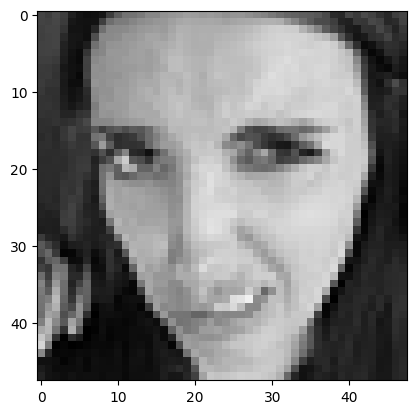


Sample Happy Traning image:


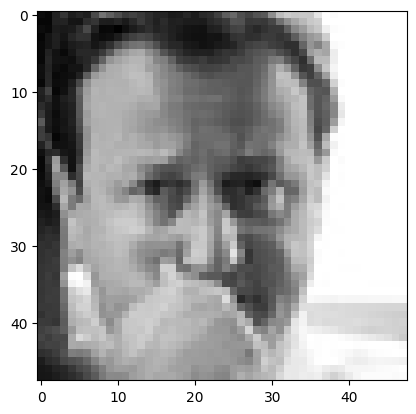

In [5]:
#so we can now see how many images we've got for each sub-genre of human facial expressions
print("Sample Disgust Training image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_Disgust_DIR, os.listdir(TRAINING_Disgust_DIR)[0])}"))
plt.show()

print("\nSample Happy Traning image:")
plt.imshow(load_img(f"{os.path.join(TRAINING_Happy_DIR, os.listdir(TRAINING_Happy_DIR)[0])}"))
plt.show()

In [6]:
#The images are blurry b/c the dimensions are 48 by 48 (quite smol so we'll have to watch out for the convulations)

In [7]:
sample_image  = load_img(f"{os.path.join(TRAINING_Happy_DIR, os.listdir(TRAINING_Happy_DIR)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (48, 48, 3)


In [8]:
#Now we make our training and validation generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):

  train_datagen = ImageDataGenerator(rescale=1/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest' )


  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32,
                                                      class_mode='categorical',
                                                      target_size=(75,  75))


  validation_datagen = ImageDataGenerator(rescale=1/255.0 )

  validation_generator = validation_datagen.flow_from_directory(directory= VALIDATION_DIR,
                                                                batch_size=32,
                                                                class_mode='categorical',
                                                                target_size=(75,  75))

  return train_generator, validation_generator

In [9]:
#TRAINING_DIR = source_path_train
#VALIDATION_DIR = source_path_validation
#
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [10]:
#yay
#Now I have to use a pre-trained model so let's see, I might go with Inception since it's what was taught in the course

In [11]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /news/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-02-09 10:52:10--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 209.85.234.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/news/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/news/inception_v3_ 100%[===================>]  83.84M   140MB/s    in 0.6s    

2024-02-09 10:52:11 (140 MB/s) - ‘/news/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/news/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [13]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(input_shape = (75,75,3),
                                  include_top = False,
                                  weights = None)

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  return pre_trained_model

In [14]:
pre_trained_model = create_pre_trained_model(local_weights_file)
# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 37, 37, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 37, 37, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 37, 37, 32)           0         ['batch_normalizati

In [15]:
# Define a Callback class that stops training once accuracy reaches 90% (which seems tough since on attempt1 it was barely 62%)
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True

In [16]:
#now let's glue Inception with my model
def output_of_last_layer(pre_trained_model):
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  return last_output

In [17]:

last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 3, 3, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 3, 3, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [18]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.src.engine.functional.Functional'>


In [19]:
def create_final_model(pre_trained_model, last_output):

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(7, activation='softmax')(x)

  # Create the complete model by using the Model class
  model = Model(pre_trained_model.input,x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [20]:
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 16,061,351 total parameters in this model.
There are 7,086,087 trainable parameters in this model.


In [21]:
print(pre_trained_model.output_shape)


(None, 1, 1, 2048)


In [22]:
callbacks = myCallback()

history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
901/901 - 77s - loss: 1.6368 - accuracy: 0.3661 - val_loss: 1.4833 - val_accuracy: 0.4349 - 77s/epoch - 86ms/step
Epoch 2/100
901/901 - 66s - loss: 1.5366 - accuracy: 0.4054 - val_loss: 1.4861 - val_accuracy: 0.4489 - 66s/epoch - 73ms/step
Epoch 3/100
901/901 - 64s - loss: 1.5132 - accuracy: 0.4181 - val_loss: 1.3941 - val_accuracy: 0.4727 - 64s/epoch - 71ms/step
Epoch 4/100
901/901 - 66s - loss: 1.4994 - accuracy: 0.4224 - val_loss: 1.4285 - val_accuracy: 0.4670 - 66s/epoch - 73ms/step
Epoch 5/100
901/901 - 64s - loss: 1.4823 - accuracy: 0.4312 - val_loss: 1.3812 - val_accuracy: 0.4778 - 64s/epoch - 71ms/step
Epoch 6/100
901/901 - 65s - loss: 1.4778 - accuracy: 0.4380 - val_loss: 1.4070 - val_accuracy: 0.4717 - 65s/epoch - 72ms/step
Epoch 7/100
901/901 - 65s - loss: 1.4634 - accuracy: 0.4448 - val_loss: 1.3642 - val_accuracy: 0.4888 - 65s/epoch - 72ms/step
Epoch 8/100
901/901 - 65s - loss: 1.4522 - accuracy: 0.4494 - val_loss: 1.3612 - val_accuracy: 0.4933 - 65s/epoch - 72

In [23]:
# Test the train_generator since I got some errors in the upper blocks
for batch in train_generator:
    print("Batch shape:", batch[0].shape)
    print("Label shape:", batch[1].shape)
    break

# Test the validation_generator
for batch in validation_generator:
    print("Batch shape:", batch[0].shape)
    print("Label shape:", batch[1].shape)
    break


Batch shape: (32, 75, 75, 3)
Label shape: (32, 7)
Batch shape: (32, 75, 75, 3)
Label shape: (32, 7)


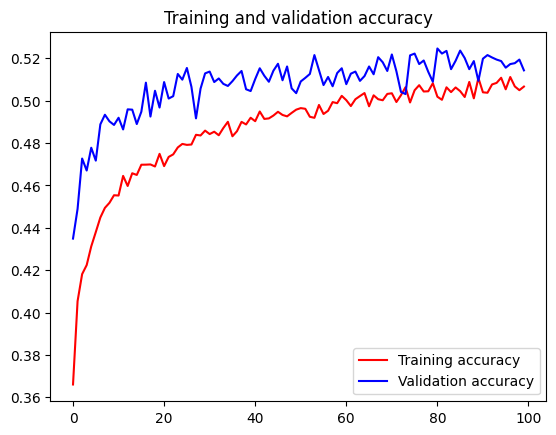

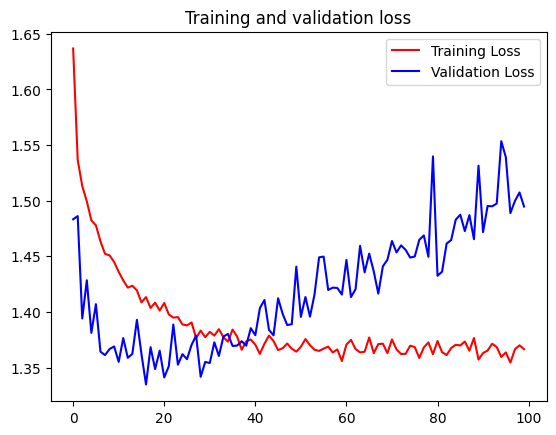

In [24]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
#conclusion? pick a better dataset